<img src="../img/hu-logo.png" align="right" width="120">

# Exercise 04: Cluster analysis and logistic regression

## Dr. D's Grocery Store - Revisited

Remember Dr. D, the proud owner of a small neighborhood grocery stores we met in exercise 03. The loyalty card program Dr. D launched allows him to collect data on the shopping behavior of his customers. 

The consulting company _Accidenture_ suggested that shoppers can be grouped into three shopper segments:
- The Obnoxious Teens
- The Prepper
- The Shopper-for-Hire

Today, we will use cluster analysis to (hopefully) validate their findings.

We will then build a (binary) classifier that can predict whether a shoppers is a cherry picker (`1`) or not (`0`).

<img src=../img/grocery.png width=800>

## Setup

In [1]:
import os
import patsy
import itertools
import functools

import numpy as np
import pandas as pd

import sklearn.cluster
import sklearn.metrics
import sklearn.datasets
import sklearn.preprocessing
import sklearn.neighbors
import sklearn.model_selection
import sklearn.linear_model

import statsmodels.api as sm

import matplotlib.cm
import matplotlib.colors
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_palette("Paired")

plt.rcParams.update({
    "figure.figsize": (10, 8),
    "axes.titlesize": 20,
    "axes.labelsize": 15,
    "legend.fontsize": 15,
    "axes.grid": True,
    "axes.axisbelow": True,
    "pcolor.shading": "auto",
})

<br>
<br>

# Part 1: Cluster analysis

## k-Means clustering

### Background k-Means clustering

The k-Means algorithm clusters data by trying to
- separate samples in n groups 
- of equal variance,
- minimizing a criterion known as the inertia or within-cluster sum-of-squares.

This algorithm requires the number of clusters to be specified.

The k-Means algorithm divides a set of $N$ samples $X$ into $K$ disjoint clusters $C$, each described by the mean $\mu_j$ of the samples in the cluster (centroids).

The k-Means algorithm aims to choose centroids that minimise the within-cluster sum-of-squares criterion, a measure of how internally coherent clusters are:

$$\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)$$

### Caveats

- k-Means assumes that clusters are convex and isotropic.
- k-Means responds poorly to elongated clusters, or manifolds with irregular shapes.
- WSS is _*not*_ a normalized metric, but we know that lower values are better and zero is optimal. 
- In very high-dimensional spaces, Euclidean distances tend to become inflated. Running a dimensionality reduction algorithm such as Principal component analysis (PCA) prior to k-Means clustering can alleviate this problem and speed up the computations.

[(Source)](https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py)

### Data

Use `sklearn`'s data generation functionality

In [3]:
n_samples = 1_500

X, y = sklearn.datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=1.0,
    random_state=170
)

### Configs

In [4]:
config_kmeans = {
    "n_clusters": 3,
    "random_state": 170
}

config_kmeans_k2 = {
    "n_clusters": 2,
    "random_state": 170
}

### Case 1: Incorrect Number of Blobs

In [5]:
scatterplot = functools.partial(sns.scatterplot, s=100, palette="Paired")

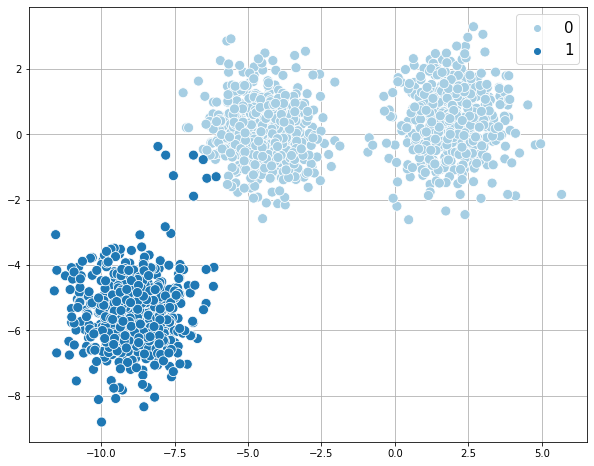

In [6]:
# fit k-means
y_pred = sklearn.cluster.KMeans(
    **config_kmeans_k2
).fit_predict(X)

# plot with predicted cluster labels
_ = scatterplot(
    x=X[:, 0],
    y=X[:, 1],
    hue=y_pred,
)

### Case 2: Anisotropicly distributed data

- Isotropic: Properties of data are identical in all directions
- Anisotropic: Properties of data depend on the direction

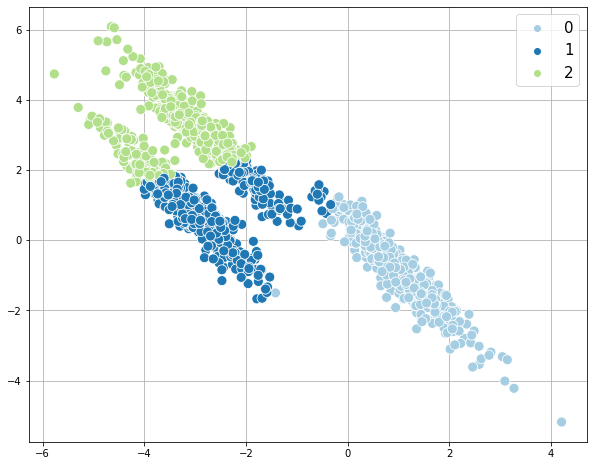

In [7]:
# transform data
X_aniso = np.dot(
    X,
    [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
)

# fit k-means
y_pred_aniso = sklearn.cluster.KMeans(
    **config_kmeans
).fit_predict(X_aniso)

# plot with predicted cluster labels
_ = scatterplot(
    x=X_aniso[:, 0],
    y=X_aniso[:, 1],
    hue=y_pred_aniso,
)

### Case 3: Different variance

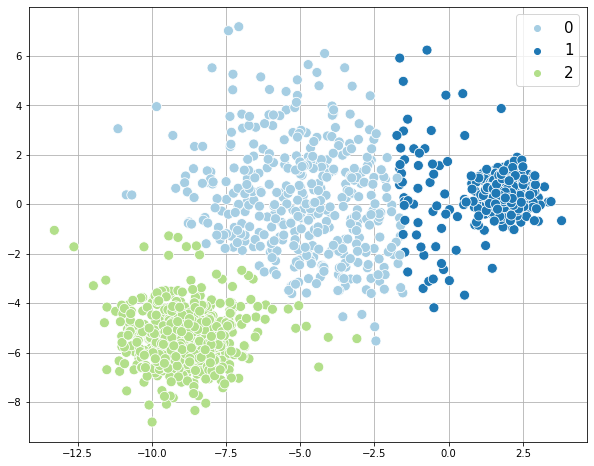

In [8]:
# create data
X_varied, y_varied = sklearn.datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=170
)

# fit k-means
y_pred_varied = sklearn.cluster.KMeans(
    **config_kmeans
).fit_predict(X_varied)

# plot with predicted cluster labels
_ = scatterplot(
    x=X_varied[:, 0],
    y=X_varied[:, 1],
    hue=y_pred_varied,
)

### Case 4: Unevenly sized blobs

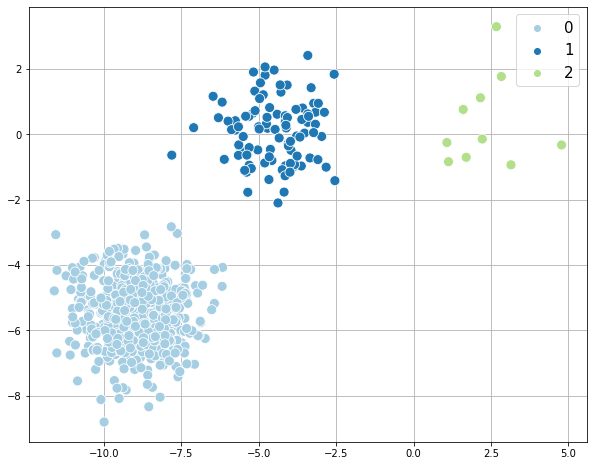

In [9]:
# transform data
X_filtered = np.vstack([
    X[y==0][:500],
    X[y==1][:100],
    X[y==2][:10]
])

# fit k-means
y_pred_filtered = sklearn.cluster.KMeans(
    **config_kmeans
).fit_predict(X_filtered)

# plot with predicted cluster labels
_ = scatterplot(
    x=X_filtered[:, 0],
    y=X_filtered[:, 1],
    hue=y_pred_filtered,
)

### All cases

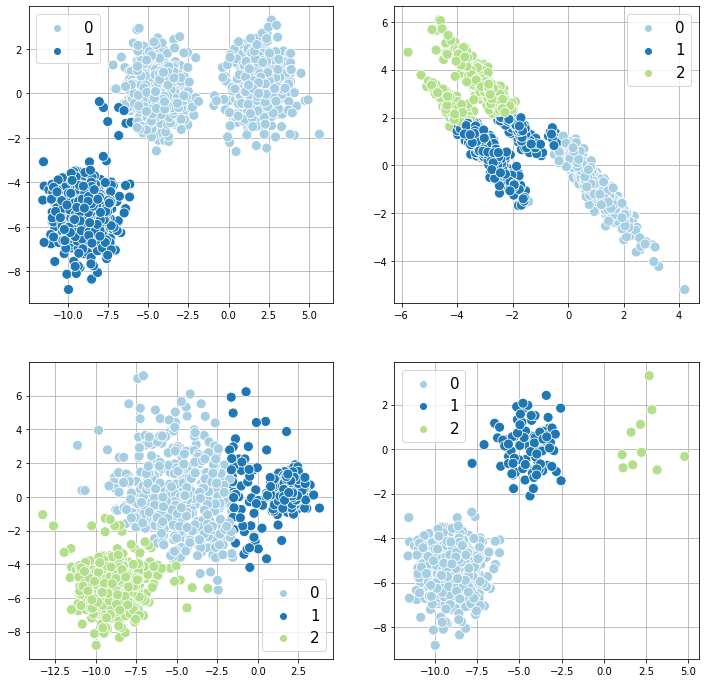

In [10]:
plt.figure(figsize=(12, 12))

plt.subplot(221)
_ = scatterplot(x=X[:, 0],          y=X[:, 1],          hue=y_pred)

plt.subplot(222)
_ = scatterplot(x=X_aniso[:, 0],    y=X_aniso[:, 1],    hue=y_pred_aniso)

plt.subplot(223)
_ = scatterplot(x=X_varied[:, 0],   y=X_varied[:, 1],   hue=y_pred_varied)

plt.subplot(224)
_ = scatterplot(x=X_filtered[:, 0], y=X_filtered[:, 1], hue=y_pred_filtered)

### Comparison to hierarchical clustering

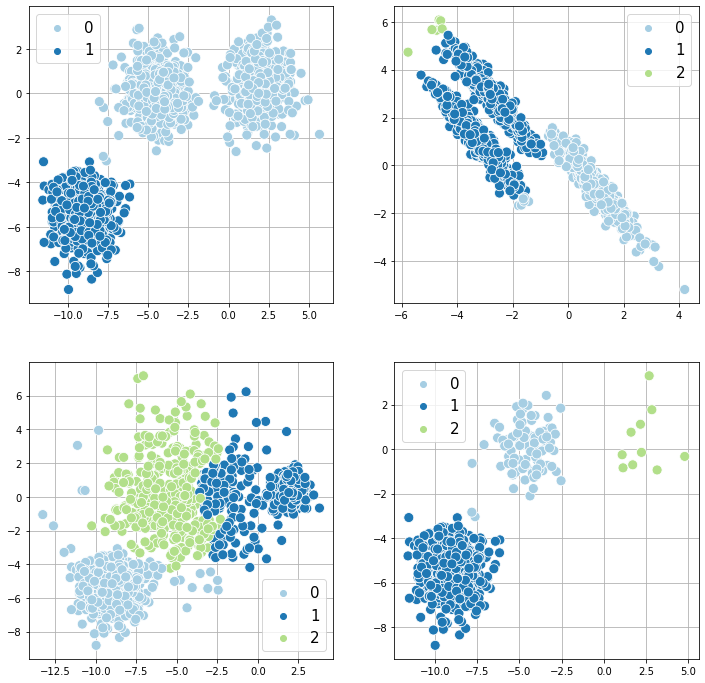

In [11]:
# data and fit k-means
model_nc2 = sklearn.cluster.AgglomerativeClustering(
    affinity="euclidean",
    linkage="average",
    n_clusters=2,
)
y_hier_pred = model_nc2.fit_predict(X)

model = sklearn.cluster.AgglomerativeClustering(
    affinity="euclidean",
    linkage="average",
    n_clusters=3,
)
y_hier_pred_aniso = model.fit_predict(X_aniso)
y_hier_pred_varied = model.fit_predict(X_varied)
y_hier_pred_filtered = model.fit_predict(X_filtered)

# plot
plt.figure(figsize=(12, 12))

plt.subplot(221)
_ = scatterplot(x=X[:, 0],          y=X[:, 1],          hue=y_hier_pred)

plt.subplot(222)
_ = scatterplot(x=X_aniso[:, 0],    y=X_aniso[:, 1],    hue=y_hier_pred_aniso)

plt.subplot(223)
_ = scatterplot(x=X_varied[:, 0],   y=X_varied[:, 1],   hue=y_hier_pred_varied)

plt.subplot(224)
_ = scatterplot(x=X_filtered[:, 0], y=X_filtered[:, 1], hue=y_hier_pred_filtered)

### Separate clusters more strongly

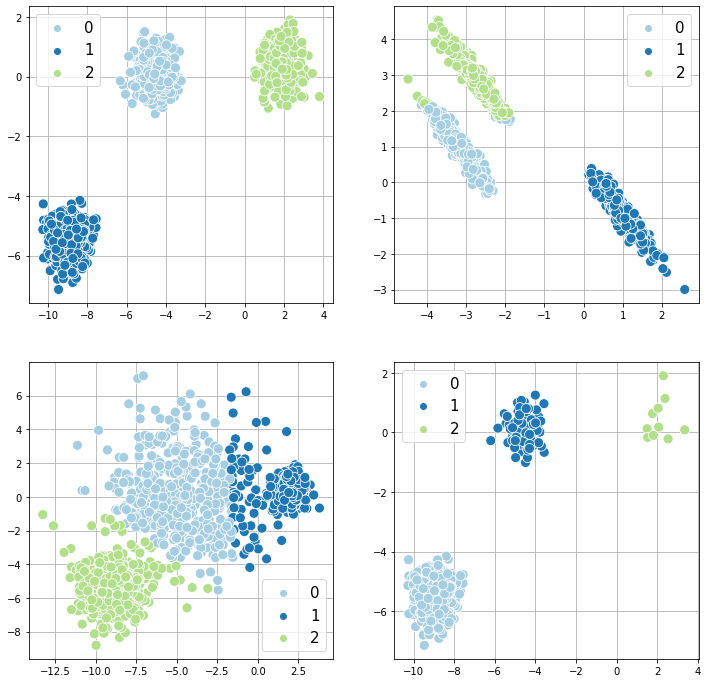

In [12]:
# data and fit k-means
X, y = sklearn.datasets.make_blobs(n_samples=n_samples, cluster_std=0.5, random_state=170)
y_pred = sklearn.cluster.KMeans(**config_kmeans).fit_predict(X)

X_aniso = np.dot(
    X,
    [[0.60834549, -0.63667341], [-0.40887718, 0.85253229]]
)
y_pred_aniso = sklearn.cluster.KMeans(**config_kmeans).fit_predict(X_aniso)

X_varied, y_varied = sklearn.datasets.make_blobs(
    n_samples=n_samples,
    cluster_std=[1.0, 2.5, 0.5],
    random_state=170
)
y_pred_varied = sklearn.cluster.KMeans(**config_kmeans).fit_predict(X_varied)

X_filtered = np.vstack([
    X[y==0][:500],
    X[y==1][:100],
    X[y==2][:10]
])
y_pred_filtered = sklearn.cluster.KMeans(**config_kmeans).fit_predict(X_filtered)

# plot
plt.figure(figsize=(12, 12))

plt.subplot(221)
_ = scatterplot(x=X[:, 0],          y=X[:, 1],          hue=y_pred)

plt.subplot(222)
_ = scatterplot(x=X_aniso[:, 0],    y=X_aniso[:, 1],    hue=y_pred_aniso)

plt.subplot(223)
_ = scatterplot(x=X_varied[:, 0],   y=X_varied[:, 1],   hue=y_pred_varied)

plt.subplot(224)
_ = scatterplot(x=X_filtered[:, 0], y=X_filtered[:, 1], hue=y_pred_filtered)

<br>
<br>

# Dr. D's Grocery Store

### Load data

In [13]:
df = pd.read_parquet("e03-dr-d-grocery.parquet")
df.head()

,shopper_id,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,segment_name,is_cherry_picker
0,shopper_000,141.817975,3.541991,0.165028,0.077541,The Obnoxious Teens,0
1,shopper_001,144.396016,3.860022,0.163544,0.069220,The Obnoxious Teens,1
2,shopper_002,130.580378,3.761713,0.149754,0.067993,The Obnoxious Teens,0
3,shopper_003,167.258689,3.555836,0.145920,0.067840,The Obnoxious Teens,0
4,shopper_004,144.925715,4.021508,0.170981,0.078963,The Obnoxious Teens,0


In [14]:
feature_variables = [
    "average_revenue",
    "average_basket_size",
    "fraction_canned_food",
    "fraction_national_brands",
]

In [15]:
df[feature_variables].describe()

,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands
count,450.000000,450.000000,450.000000,450.000000
mean,378.464356,23.884672,0.194487,0.067881
std,182.141639,15.409354,0.028280,0.009784
min,90.757119,1.769286,0.138783,0.043475
25%,160.378473,6.059692,0.171622,0.061535
50%,425.914019,26.463476,0.193793,0.067127
75%,520.202382,36.533924,0.216222,0.073704
max,759.837484,56.032508,0.266659,0.099542


In [16]:
features = df[feature_variables].values

### Plot marginals

Including k-Means decision boundaries.

In [17]:
# scale data
config_scale = {
    "with_mean": True,
    "with_std": True,
}

config_kmeans = {
    "n_clusters": 3,
    "random_state": 501,
}

In [18]:
for i, f in enumerate(feature_variables):
    print(f"Feature {i}:  {f}")

Feature 0:  average_revenue
Feature 1:  average_basket_size
Feature 2:  fraction_canned_food
Feature 3:  fraction_national_brands


In [19]:
scaler_mean_std = sklearn.preprocessing.StandardScaler(**config_scale)
features_scaled = (
    scaler_mean_std
    .fit_transform(df[feature_variables].values)
)

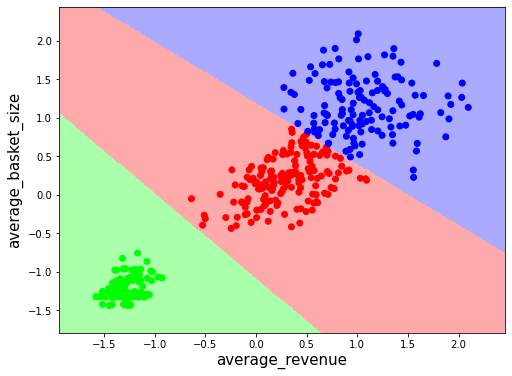

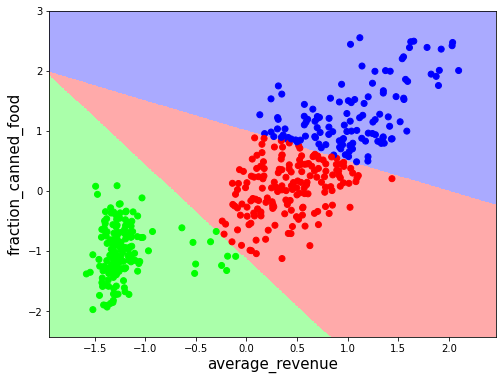

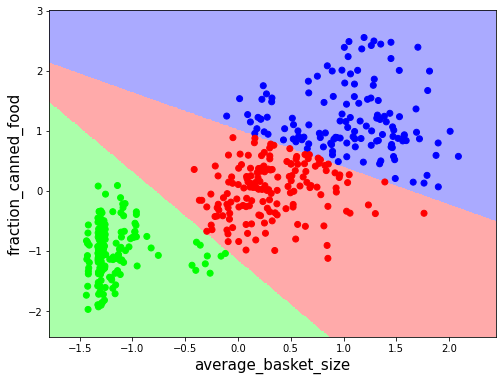

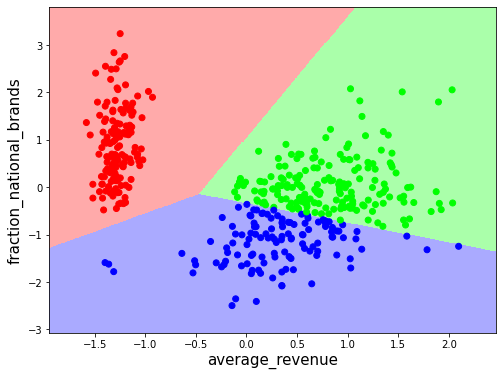

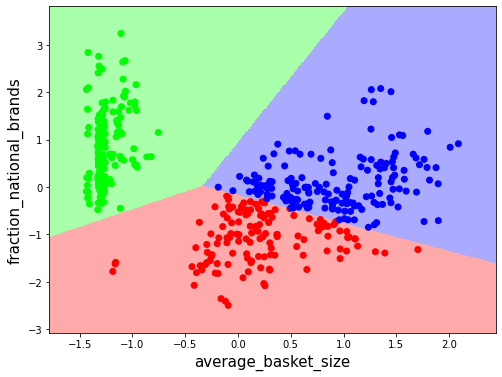

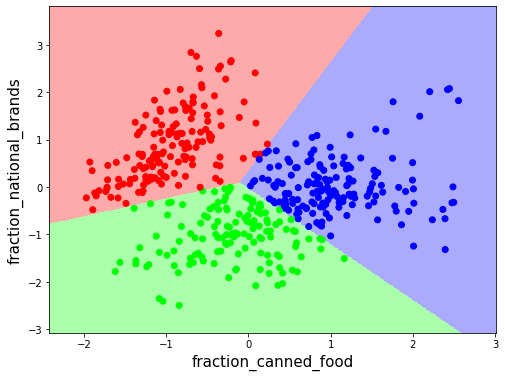

In [20]:
indices = []
for j in range(features_scaled.shape[1]):
    for i in range(j):
        if j>i:
            indices.append((i, j))

plt.rcParams["pcolor.shading"] = "auto"

for ix, iy in indices:
    
    reduced_data = features_scaled[:, [ix, iy]]

    # step size in the mesh
    h = .01

    # color maps
    cmap_light = matplotlib.colors.ListedColormap(["#FFAAAA", "#AAFFAA", "#AAAAFF"])
    cmap_bold = matplotlib.colors.ListedColormap(["#FF0000", "#00FF00", "#0000FF"])

    # fit k-means and predict labels
    kmeans = sklearn.cluster.KMeans(**config_kmeans)
    kmeans.fit(reduced_data)
    cluster_labels = kmeans.labels_

    # plot the decision boundary
    # assign a color to each point in the mesh [x_min, x_max]x[y_min, y_max]
    range_x = reduced_data[:, 0].max() - reduced_data[:, 0].min()
    x_min, x_max = reduced_data[:, 0].min() - range_x/10, reduced_data[:, 0].max() + range_x/10
    range_y = reduced_data[:, 1].max() - reduced_data[:, 1].min()
    y_min, y_max = reduced_data[:, 1].min() - range_y/10, reduced_data[:, 1].max() + range_y/10
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

    # plot
    Z = Z.reshape(xx.shape)
    plt.figure(figsize=(8,6))
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light)
    plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=cluster_labels, cmap=cmap_bold)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xlabel(f"{feature_variables[ix]}")
    plt.ylabel(f"{feature_variables[iy]}")
    plt.show()

### Determine k

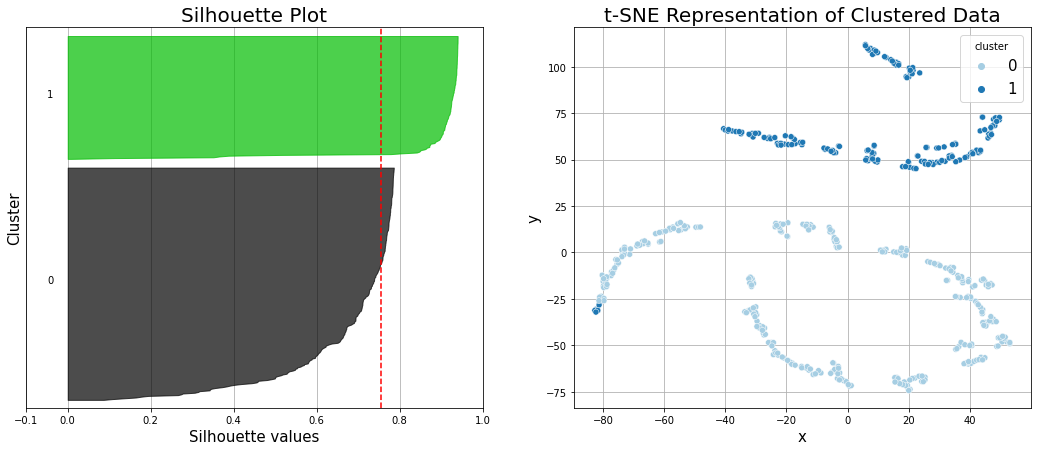

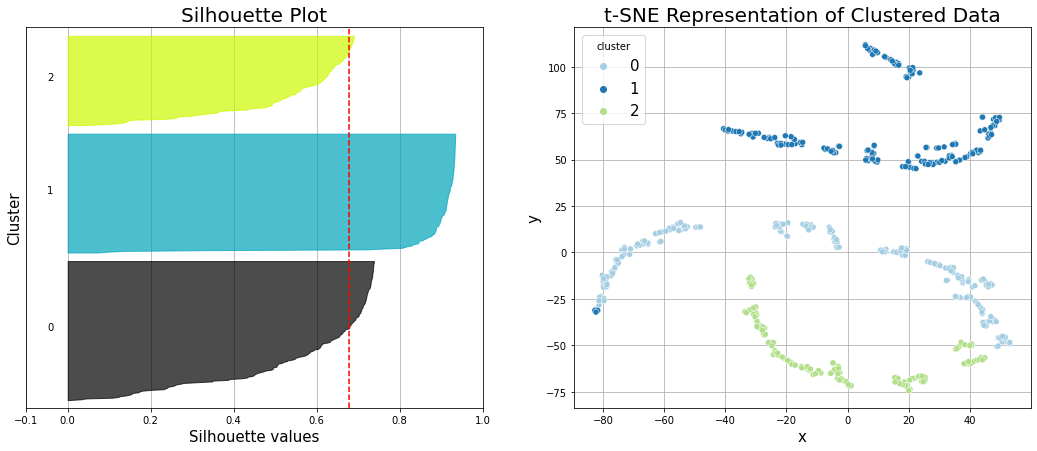

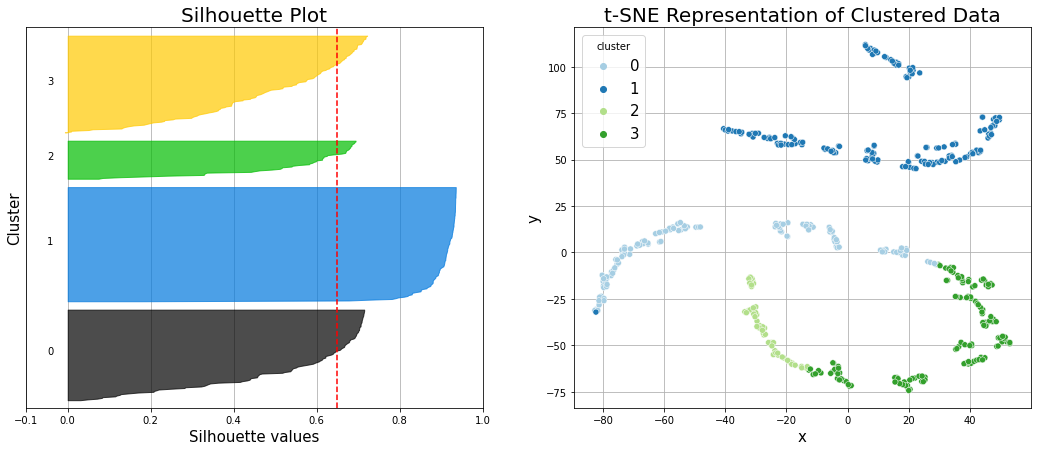

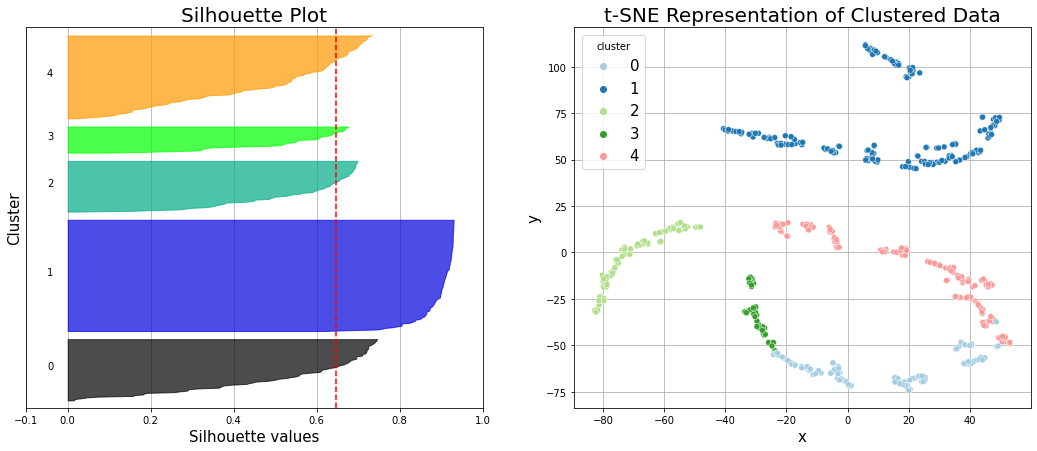

In [21]:
my_colors = sns.color_palette("Paired")

# we'll look at dimensionality reduction in lecture 07
tsne_i = sklearn.manifold.TSNE(
    random_state=4,
    n_components=2,
    n_iter=2500,
    perplexity=7,
    angle=0.5,
    verbose=0
)
res_tsne_i = tsne_i.fit_transform(features)
reduced_data = pd.DataFrame(res_tsne_i, columns=["x", "y"])

for k in [2, 3, 4, 5]:

    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(features) + (k + 1) * 10])

    # fit k-means
    kmeans = sklearn.cluster.KMeans(n_clusters=k, random_state=10)
    cluster_labels = kmeans.fit_predict(features)

    # compute silhouette scores
    silhouette_avg = sklearn.metrics.silhouette_score(features, cluster_labels)
    sample_silhouette_values = sklearn.metrics.silhouette_samples(features, cluster_labels)

    # PLOT 1: silhouette scores
    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = matplotlib.cm.nipy_spectral(float(i) / k)
        _ = ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )
        _ = ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("Silhouette Plot")
    ax1.set_xlabel("Silhouette values")
    ax1.set_ylabel("Cluster")
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # PLOT 2: t-SNE map
    reduced_data["cluster"] = cluster_labels
    _ = sns.scatterplot(
        ax=ax2,
        x="x",
        y="y",
        hue="cluster",
        data=reduced_data,
        palette=my_colors[:k]
    )
    ax2.set_title("t-SNE Representation of Clustered Data")

    plt.show()

### Result

In [22]:
k_star = 3

In [23]:
kmeans = sklearn.cluster.KMeans(
    n_clusters=k_star,
    random_state=501
)
cluster_labels = kmeans.fit_predict(features)
df["cluster"] = cluster_labels

In [24]:
confusion_matrix = (
    df
    .groupby(["cluster", "segment_name"])[["shopper_id"]]
    .count()
    .sort_values("shopper_id", ascending=False).pivot_table(
        index="cluster",
        columns="segment_name",
        fill_value=0,
    )
    .reindex(columns=[
        ("shopper_id", "The Shopper-for-Hire"),
        ("shopper_id", "The Obnoxious Teens"),
        ("shopper_id", "The Prepper")
    ])
)
confusion_matrix

shopper_id                                
segment_name The Shopper-for-Hire The Obnoxious Teens The Prepper
cluster                                                          
0                             135                   0          45
1                               4                 150           0
2                              11                   0         105

## Excusion: PCA (more details in lecture 07)

In [25]:
import sklearn.decomposition

In [26]:
pca = sklearn.decomposition.PCA(
    n_components=2,
    random_state=501,
)

In [27]:
x_reduced = pca.fit_transform(df[feature_variables].values)

In [28]:
df[feature_variables].shape

(450, 4)

In [29]:
x_reduced.shape

(450, 2)

<br>
<br>

# Part 2: Logistic regression

## Data

### Data content

The dataset (450 shoppers) contains the following variables

- `shopper_id` (object): The loyalty program ID.
- `average_revenue` (float64): Average monthly spending in USD (i.e., revenue).
- `average_basket_size` (float64): Average basket size per shopping trip (i.e., number of SKUs purchased on a trip).
- `fraction_canned_food` (float64): Fraction of purchases that are canned food products.
- `fraction_national_brands` (float64): Fraction of purchases that are products manufacturered by national brands.
- `segment_name` (object): The segment each customer was assigned to by Accidenture.
- `is_cherry_picker` (int64): A binary indicator whether a customer is considered to be a "cherry picker".

### Goal

We will then build a (binary) classifier that can predict whether a shoppers is a cherry picker (`1`) or not (`0`).

### Load data

In [30]:
df = pd.read_parquet("e03-dr-d-grocery.parquet")

In [31]:
feature_variables = ["fraction_canned_food", "fraction_national_brands", "average_revenue", "average_basket_size"]

## Review shopper types

In [32]:
df.groupby("segment_name").shopper_id.count()

segment_name
The Obnoxious Teens     150
The Prepper             150
The Shopper-for-Hire    150
Name: shopper_id, dtype: int64

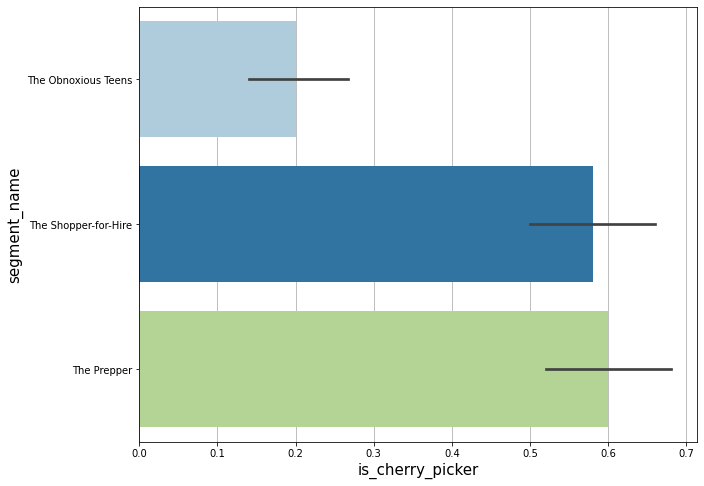

In [33]:
_ = sns.barplot(
    x="is_cherry_picker",
    y="segment_name",
    data=df
)

## Config

In [34]:
config_train_test_split = {
    "test_size": 0.2,
    "random_state": 501,
}

config_knn_classifier = {
    "n_neighbors": 10,
    "p": 2,
}

## Build `X` and `y`

In [35]:
def build_X_y(variables):
    y_df, X_df = patsy.dmatrices(
        formula_like=f"is_cherry_picker ~ {' + '.join(variables)}",
        data=df,
        return_type="dataframe"
    )
    y = y_df.values.flatten()
    X = X_df.values
    return X, y

In [36]:
variables = ["fraction_canned_food", "fraction_national_brands", "average_revenue", "average_basket_size"]
f"is_cherry_picker ~ {' + '.join(variables)}"

'is_cherry_picker ~ fraction_canned_food + fraction_national_brands + average_revenue + average_basket_size'

In [37]:
X, y = build_X_y(["fraction_canned_food", "fraction_national_brands", "average_revenue", "average_basket_size"])

## Train-test split

In [38]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    **config_train_test_split
)

## Background on evaluation for binary classification

### Confusion matrix

<img src=../img/confusion.png width="1200">

[(Source)](https://en.wikipedia.org/wiki/Confusion_matrix)

### Accuracy

Fraction of positives

$
\quad Accuracy = \displaystyle\frac{TP + TN}{TP + TN + FP + FN}
$

### Precision and Recall

<img src="../img/precision-recall.png" width="600">

True positives divided by condition positive

$
\quad Recall = \displaystyle\frac{TP}{TP + FN}
$

True positives divided by predicted positive

$
\quad Precision = \displaystyle\frac{TP}{TP + FP}
$


The F1 score is the harmonic mean of the precision and recall

$
\quad F1\, Score = \displaystyle 2 \times \frac{Precision \times Recall}{Precision + Recall}
$

and it reaches its best value at 1 (perfect precision and recall) and worst at 0.

## k-NN

In [39]:
def knn_pipeline(X_train, X_test, y_train, y_test, config_knn_classifier):
    # model
    knn = sklearn.neighbors.KNeighborsClassifier(**config_knn_classifier)
    knn.fit(X_train, y_train)
    
    # predict
    y_pred_train = knn.predict(X_train)
    y_pred_test = knn.predict(X_test)
    
    # benchmark
    return np.mean(y_pred_train==y_train), np.mean(y_pred_test==y_test)

In [40]:
knn_pipeline(X_train, X_test, y_train, y_test, config_knn_classifier)

(0.6916666666666667, 0.6333333333333333)

## Logistic regression with `statsmodels`

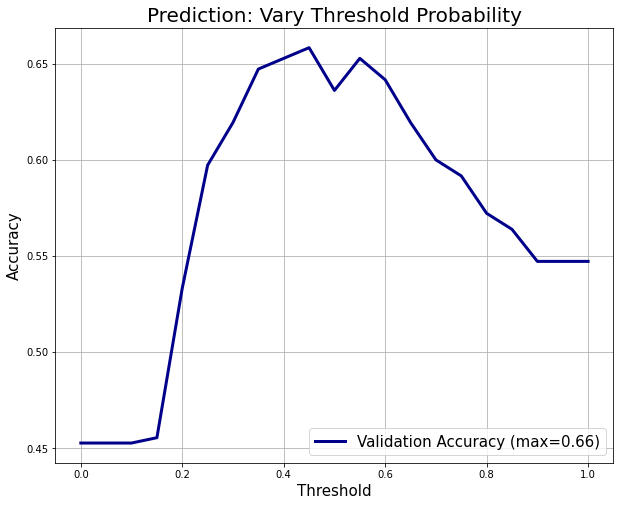

In [41]:
# grid search threshold on validation set (CV)
thresholds = np.linspace(0, 1, 21)
accuracy = np.empty(len(thresholds))

for i, threshold in enumerate(thresholds):
    # folds
    cv = sklearn.model_selection.StratifiedKFold(n_splits=4)

    # loop over folds and compute accuracy
    accuracy_threshold = np.zeros(4)
    for j, (train, val) in enumerate(cv.split(X_train, y_train)):
        sm_logit = sm.Logit(endog=y_train[train], exog=X_train[train,:])
        sm_result = sm_logit.fit(disp=False)
        accuracy_threshold[j] = np.mean(
            (sm_result.predict(X_train[val,:])>=threshold).astype(int) == y_train[val]
        )

    # average accuracy
    accuracy[i] = np.mean(accuracy_threshold)

# plot
plt.plot(thresholds, accuracy, c="darkblue", linewidth=3, label=f"Validation Accuracy (max={max(accuracy):.2f})")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Prediction: Vary Threshold Probability")
plt.show()

In [42]:
y_pred = sm_result.predict(X_test)
y_pred_bin = (y_pred>thresholds[np.argmax(accuracy)]).astype(int)

print(f"Accuracy: {np.mean(y_pred_bin == y_test):2f}")

Accuracy: 0.666667


## Let's go back to the feature variables

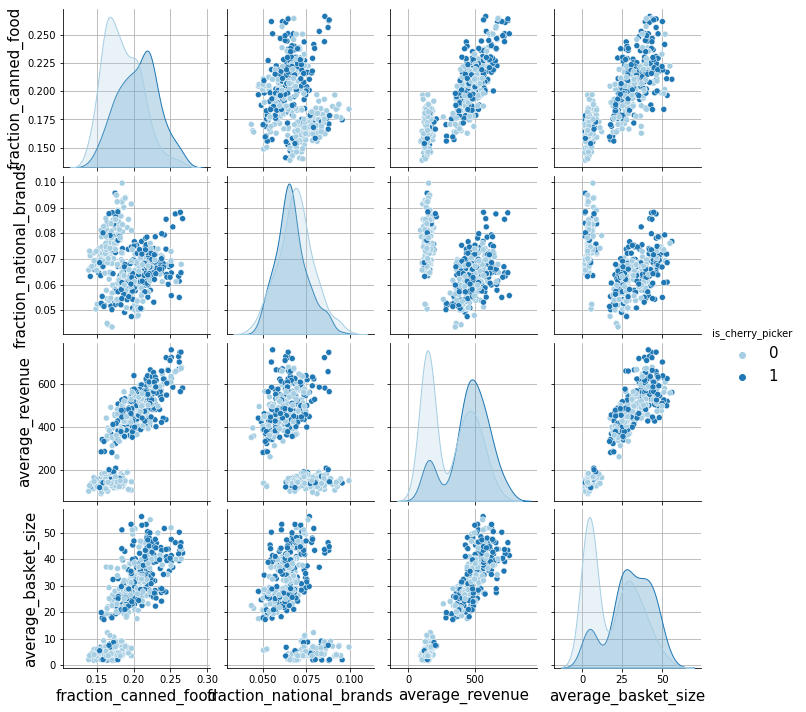

In [43]:
_ = sns.pairplot(
    df,
    vars=feature_variables,
    hue="is_cherry_picker"
)

In [44]:
df.corr()

,average_revenue,average_basket_size,fraction_canned_food,fraction_national_brands,is_cherry_picker
average_revenue,1.000000,0.928918,0.844125,-0.412949,0.399103
average_basket_size,0.928918,1.000000,0.793483,-0.351109,0.364673
fraction_canned_food,0.844125,0.793483,1.000000,-0.110641,0.376422
fraction_national_brands,-0.412949,-0.351109,-0.110641,1.000000,-0.121247
is_cherry_picker,0.399103,0.364673,0.376422,-0.121247,1.000000


In [45]:
X, y = build_X_y(["fraction_canned_food", "average_revenue"])

In [46]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X,
    y,
    **config_train_test_split
)

### New k-NN

In [47]:
knn_pipeline(X_train, X_test, y_train, y_test, config_knn_classifier)

(0.6805555555555556, 0.5555555555555556)

### New Logistic regression with `statsmodels`

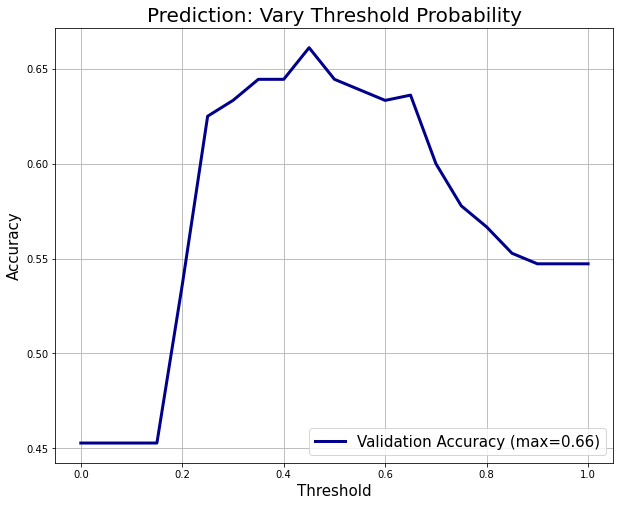

In [48]:
thresholds = np.linspace(0, 1, 21)
accuracy = np.empty(len(thresholds))

for i, threshold in enumerate(thresholds):

    cv = sklearn.model_selection.StratifiedKFold(n_splits=4)

    accuracy_threshold = np.zeros(4)
    for j, (train, val) in enumerate(cv.split(X_train, y_train)):
        sm_logit = sm.Logit(endog=y_train[train], exog=X_train[train,:])
        sm_result = sm_logit.fit(disp=False)
        accuracy_threshold[j] = np.mean(
            (sm_result.predict(X_train[val,:])>=threshold).astype(int) == y_train[val]
        )
    accuracy[i] = np.mean(accuracy_threshold)

plt.plot(thresholds, accuracy, c="darkblue", linewidth=3, label=f"Validation Accuracy (max={max(accuracy):.2f})")
plt.legend()
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.title("Prediction: Vary Threshold Probability")
plt.show()

In [49]:
y_pred = sm_result.predict(X_test)
y_pred_bin = (y_pred>=thresholds[np.argmax(accuracy)]).astype(int)

print(f"Accuracy: {np.mean(y_pred_bin == y_test):2f}")

Accuracy: 0.700000


### More evaluations

In [50]:
sklearn.metrics.confusion_matrix(y_test, y_pred_bin)

array([[30, 16],
       [11, 33]])

In [51]:
print(sklearn.metrics.classification_report(y_test, y_pred_bin))

              precision    recall  f1-score   support

         0.0       0.73      0.65      0.69        46
         1.0       0.67      0.75      0.71        44

    accuracy                           0.70        90
   macro avg       0.70      0.70      0.70        90
weighted avg       0.70      0.70      0.70        90



## ROC Curve and AUC

Is there a way to evaluate a binary classifier independent of the threshold probability?

### ROC Curve

A receiver operating characteristic curve, or ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied.

The ROC curve is created by plotting the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. It can also be thought of as a plot of the power (the probability of avoiding a type II error) as a function of the type I error of the decision rule.

### AUC

AUC stands for "Area under the ROC Curve." AUC measures the entire two-dimensional area underneath the entire ROC curve (think integral) from (0,0) to (1,1). AUC values range from 0 to 1. A (biased) coinflip has a AUC score of 0.5.

- AUC is scale-invariant. It measures how well predictions are ranked, rather than their absolute values.
- AUC is classification-threshold-invariant. It measures the quality of the model's predictions irrespective of what classification threshold is chosen.

Can you think of situations where these properies are not desirable?

### Example for `statsmodels` result

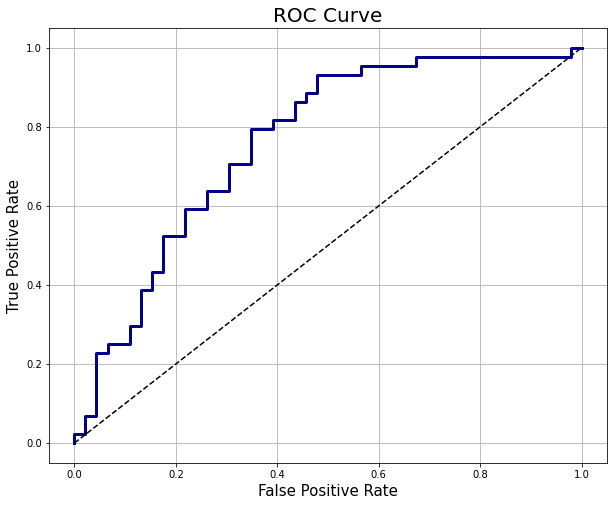

In [52]:
y_pred_pr = sm_result.predict(X_test)

fpr, tpr, thresholds = sklearn.metrics.roc_curve(y_test, y_pred_pr)

# Plot ROC curve
plt.plot([0, 1], [0, 1], "k--")
plt.plot(fpr, tpr, c="darkblue", linewidth=3)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

In [53]:
print("AUC: {}".format(sklearn.metrics.roc_auc_score(y_test, y_pred_pr)))

AUC: 0.7608695652173912


&mdash; <br>
Dr. Sebastian Gabel <br>
Machine Learning in Marketing &ndash; Exercise 4 <br>
&copy; 2020 <br>